In [1]:
# Instala librerías necesarias
!pip install torch


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
# Importa las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
from scipy.interpolate import griddata

## A - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,3,3,1]

### I - Grilla de 5 x 5:

PINN:

Epoch 0, Loss: 0.14242419600486755
Epoch 100, Loss: 0.1071586012840271
Epoch 200, Loss: 0.0987359806895256
Epoch 300, Loss: 0.08940784633159637
Epoch 400, Loss: 0.07538605481386185
Epoch 500, Loss: 0.06573650240898132
Epoch 600, Loss: 0.059115782380104065
Epoch 700, Loss: 0.03769620507955551
Epoch 800, Loss: 0.015374349430203438
Epoch 900, Loss: 0.014414854347705841
Epoch 1000, Loss: 0.013561402447521687
Epoch 1100, Loss: 0.01272241584956646
Epoch 1200, Loss: 0.01187824085354805
Epoch 1300, Loss: 0.010989581234753132
Epoch 1400, Loss: 0.009920761920511723
Epoch 1500, Loss: 0.00823581125587225
Epoch 1600, Loss: 0.005976580549031496
Epoch 1700, Loss: 0.003520171158015728
Epoch 1800, Loss: 0.002333037555217743
Epoch 1900, Loss: 0.002026444999501109
Epoch 2000, Loss: 0.0018782104598358274
Epoch 2100, Loss: 0.0017669277731329203
Epoch 2200, Loss: 0.0016760795842856169
Epoch 2300, Loss: 0.0016003187047317624
Epoch 2400, Loss: 0.001536059775389731
Epoch 2500, Loss: 0.0014805567916482687
Epoch

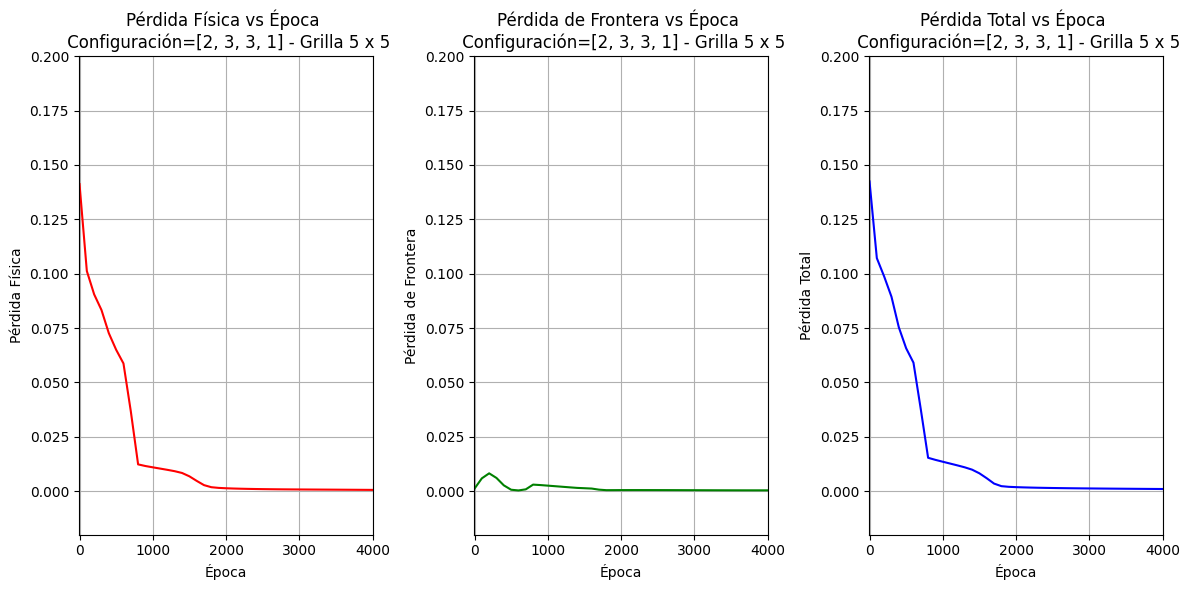

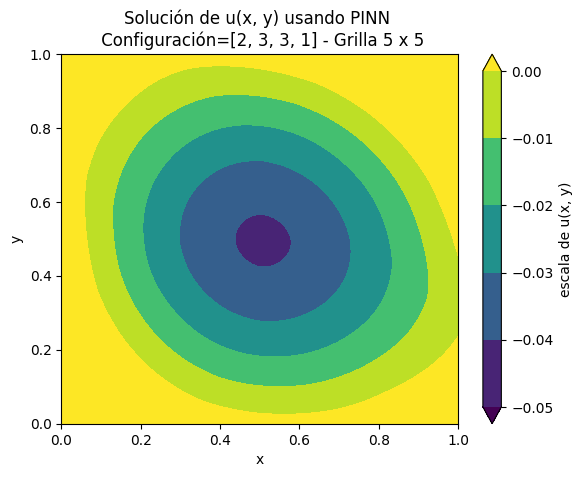

In [69]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 5x5 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua el modelo en la malla definida
u_pred_5x5 = trained_model(x, y).detach().numpy()
u_pred_5x5 = u_pred_5x5.reshape(5, 5)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_5x5.flatten(), y_5x5.flatten())).T
values = u_pred_5x5.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 3, 3, 1] - Grilla 5 x 5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\988094919.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_5x5.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\988094919.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev`

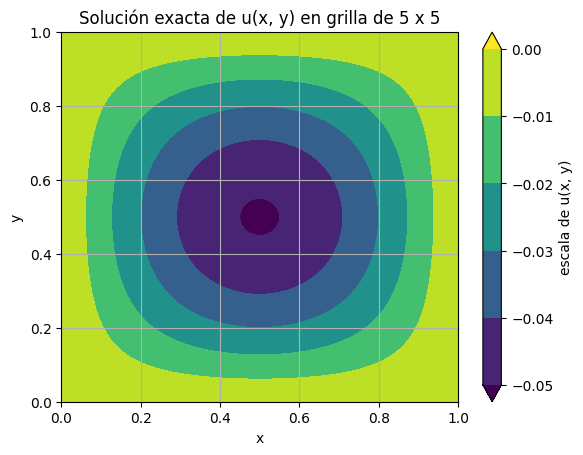

In [70]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_5x5 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_5x5.T, kind='cubic') 
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 5 x 5')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\2100537038.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_5x5, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\2100537038.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bi

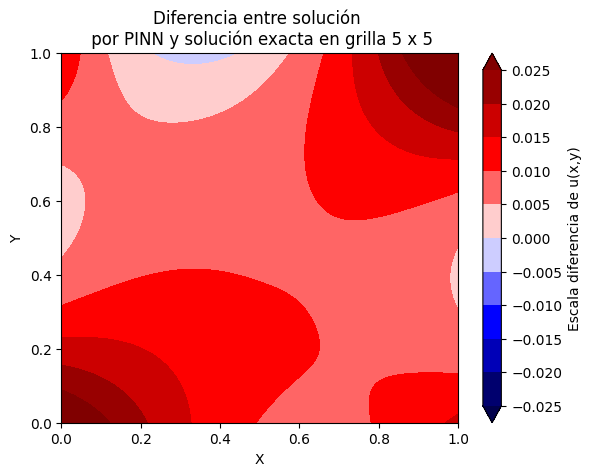

In [71]:
# Calcula la diferencia entre los dos campos
diferencia_5x5 = u_pred_5x5 - u_SE_5x5

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_5x5.shape[1])
y = np.linspace(0, 1, diferencia_5x5.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_5x5, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.025, -0.020, -0.015, -0.010, -0.005, 0.000, 0.005, 0.010, 0.015, 0.020, 0.025], vmin=-0.025, vmax=0.025, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.025, -0.020, -0.015, -0.010, -0.005, 0.000, 0.005, 0.010, 0.015, 0.020, 0.025])
plt.title('Diferencia entre solución \n por PINN y solución exacta en grilla 5 x 5')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_5x5

### II - Grilla de 10 x 10:

Epoch 0, Loss: 0.21961988508701324
Epoch 100, Loss: 0.11555730551481247
Epoch 200, Loss: 0.06448613107204437
Epoch 300, Loss: 0.060259707272052765
Epoch 400, Loss: 0.058927156031131744
Epoch 500, Loss: 0.05834586173295975
Epoch 600, Loss: 0.057821087539196014
Epoch 700, Loss: 0.0570312924683094
Epoch 800, Loss: 0.05552411451935768
Epoch 900, Loss: 0.05206036940217018
Epoch 1000, Loss: 0.0424012765288353
Epoch 1100, Loss: 0.01734342984855175
Epoch 1200, Loss: 0.009450041688978672
Epoch 1300, Loss: 0.007934710010886192
Epoch 1400, Loss: 0.006794444750994444
Epoch 1500, Loss: 0.00581008568406105
Epoch 1600, Loss: 0.004939582664519548
Epoch 1700, Loss: 0.004246749449521303
Epoch 1800, Loss: 0.0037664370611310005
Epoch 1900, Loss: 0.0034605797845870256
Epoch 2000, Loss: 0.0032709978986531496
Epoch 2100, Loss: 0.0031525129452347755
Epoch 2200, Loss: 0.003075884422287345
Epoch 2300, Loss: 0.0030227736569941044
Epoch 2400, Loss: 0.0029818841721862555
Epoch 2500, Loss: 0.002946605673059821
Epoc

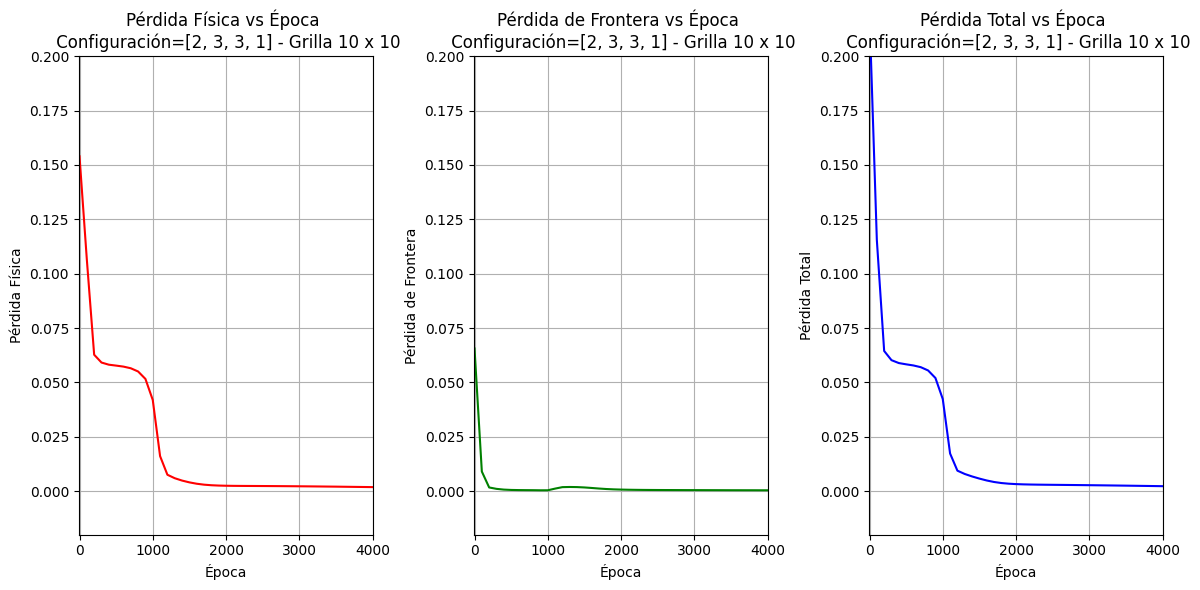

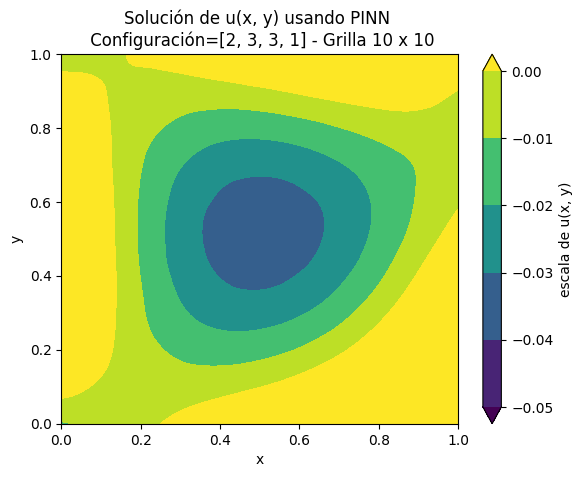

In [72]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 10x10 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua el modelo en la malla definida
u_pred_10x10 = trained_model(x, y).detach().numpy()
u_pred_10x10 = u_pred_10x10.reshape(10, 10)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_10x10.flatten(), y_10x10.flatten())).T
values = u_pred_10x10.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 3, 3, 1] - Grilla 10 x 10")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\879026258.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_10x10.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\879026258.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisple

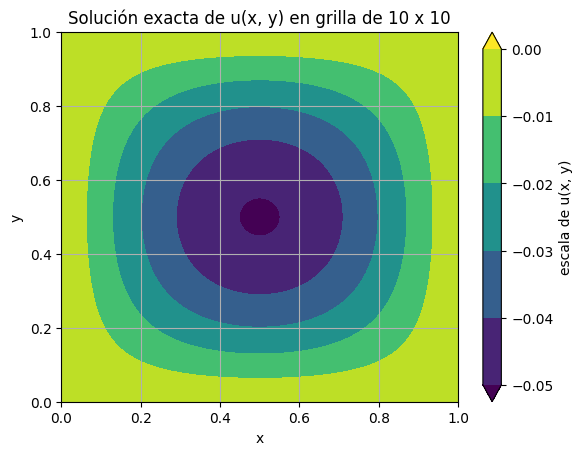

In [73]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_10x10 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_10x10.T, kind='cubic')  
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 10 x 10')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\562207402.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_10x10, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\562207402.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bi

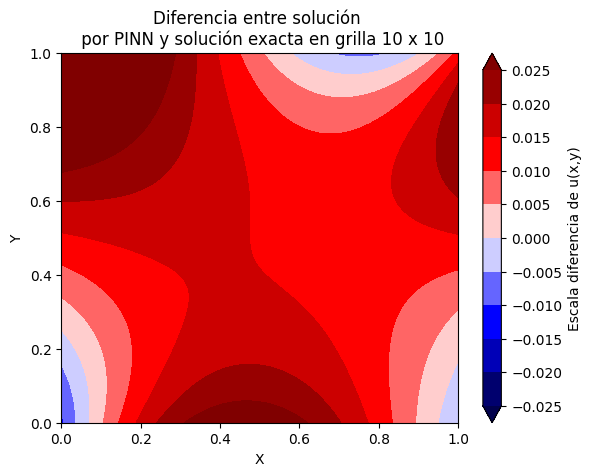

In [74]:
# Calcula la diferencia entre los dos campos
diferencia_10x10 = u_pred_10x10 - u_SE_10x10

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_10x10.shape[1])
y = np.linspace(0, 1, diferencia_10x10.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_10x10, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.025, -0.020, -0.015, -0.010, -0.005, 0.000, 0.005, 0.010, 0.015, 0.020, 0.025], vmin=-0.025, vmax=0.025, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.025, -0.020, -0.015, -0.010, -0.005, 0.000, 0.005, 0.010, 0.015, 0.020, 0.025])
plt.title('Diferencia entre solución \n por PINN y solución exacta en grilla 10 x 10')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_10x10

### III - Grilla de 20 x 20:

Epoch 0, Loss: 0.4946001172065735
Epoch 100, Loss: 0.27924805879592896
Epoch 200, Loss: 0.22557049989700317
Epoch 300, Loss: 0.20577354729175568
Epoch 400, Loss: 0.11850403249263763
Epoch 500, Loss: 0.07580012828111649
Epoch 600, Loss: 0.07123702764511108
Epoch 700, Loss: 0.06775375455617905
Epoch 800, Loss: 0.06420537829399109
Epoch 900, Loss: 0.060530081391334534
Epoch 1000, Loss: 0.05698263645172119
Epoch 1100, Loss: 0.054886262863874435
Epoch 1200, Loss: 0.05436397343873978
Epoch 1300, Loss: 0.054163530468940735
Epoch 1400, Loss: 0.05402343347668648
Epoch 1500, Loss: 0.05391378700733185
Epoch 1600, Loss: 0.053823333233594894
Epoch 1700, Loss: 0.05374569073319435
Epoch 1800, Loss: 0.05367571488022804
Epoch 1900, Loss: 0.053607553243637085
Epoch 2000, Loss: 0.05353236943483353
Epoch 2100, Loss: 0.053432490676641464
Epoch 2200, Loss: 0.0532599575817585
Epoch 2300, Loss: 0.052826836705207825
Epoch 2400, Loss: 0.05088571459054947
Epoch 2500, Loss: 0.03865742310881615
Epoch 2600, Loss: 0

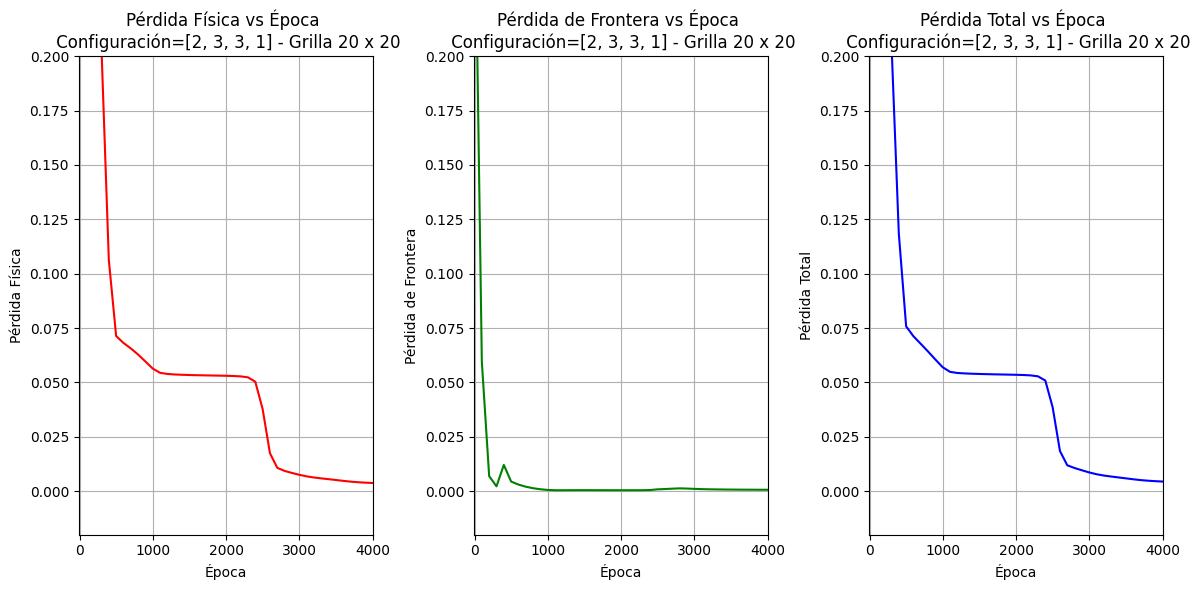

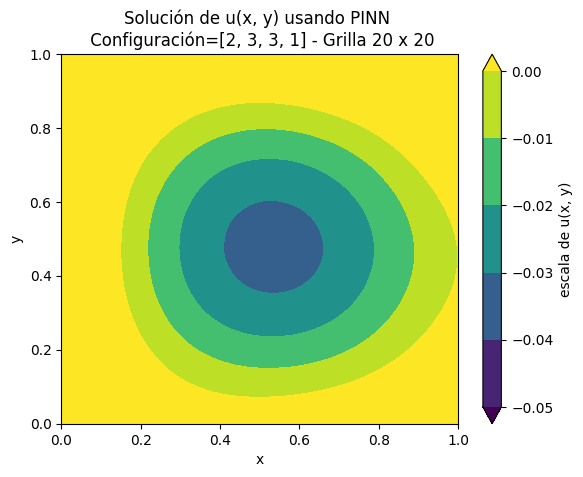

In [75]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 3)  # Entrada
        self.fc2 = nn.Linear(3, 3)  # Capa oculta 1
        self.fc3 = nn.Linear(3, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 20x20 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua el modelo en la malla definida
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_20x20.flatten(), y_20x20.flatten())).T
values = u_pred_20x20.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 3, 3, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\3261108849.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\3261108849.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisp

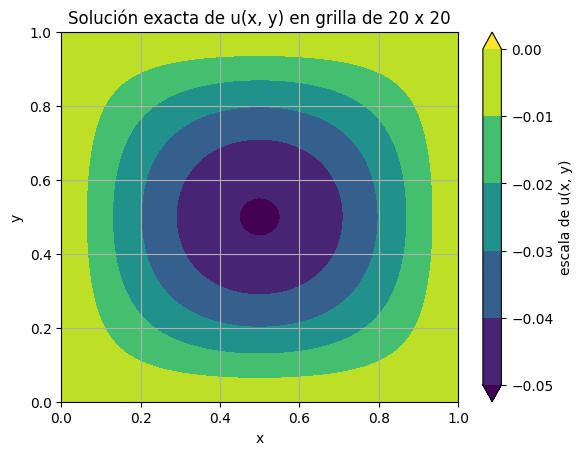

In [76]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')  
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\609832916.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\609832916.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bi

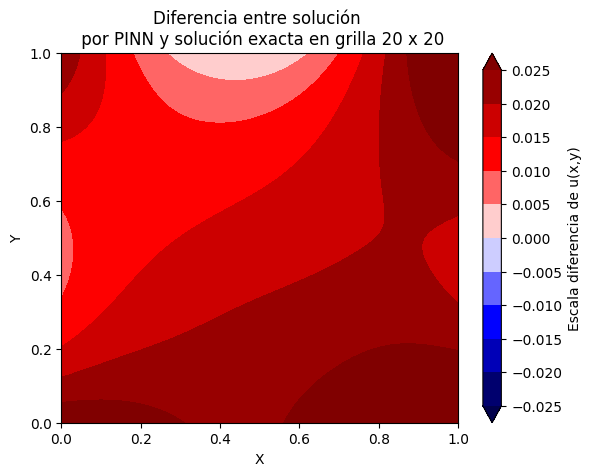

In [77]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.025, -0.020, -0.015, -0.010, -0.005, 0.000, 0.005, 0.010, 0.015, 0.020, 0.025], vmin=-0.025, vmax=0.025, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.025, -0.020, -0.015, -0.010, -0.005, 0.000, 0.005, 0.010, 0.015, 0.020, 0.025])
plt.title('Diferencia entre solución \n por PINN y solución exacta en grilla 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20

## B - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,5,5,1]

### I - Grilla de 5 x 5:

Epoch 0, Loss: 0.3531428575515747
Epoch 100, Loss: 0.13394874334335327
Epoch 200, Loss: 0.08962726593017578
Epoch 300, Loss: 0.07496927678585052
Epoch 400, Loss: 0.06441070884466171
Epoch 500, Loss: 0.050528693944215775
Epoch 600, Loss: 0.03398783877491951
Epoch 700, Loss: 0.017255190759897232
Epoch 800, Loss: 0.010912086814641953
Epoch 900, Loss: 0.00806772243231535
Epoch 1000, Loss: 0.0064016045071184635
Epoch 1100, Loss: 0.005396050401031971
Epoch 1200, Loss: 0.004714926704764366
Epoch 1300, Loss: 0.004179038573056459
Epoch 1400, Loss: 0.0037197545170783997
Epoch 1500, Loss: 0.0033160937018692493
Epoch 1600, Loss: 0.002964592073112726
Epoch 1700, Loss: 0.00266788387671113
Epoch 1800, Loss: 0.002428184961900115
Epoch 1900, Loss: 0.0022424443159252405
Epoch 2000, Loss: 0.0021018791012465954
Epoch 2100, Loss: 0.001995239406824112
Epoch 2200, Loss: 0.0019118303898721933
Epoch 2300, Loss: 0.0018429466290399432
Epoch 2400, Loss: 0.0017823053058236837
Epoch 2500, Loss: 0.001725912559777498

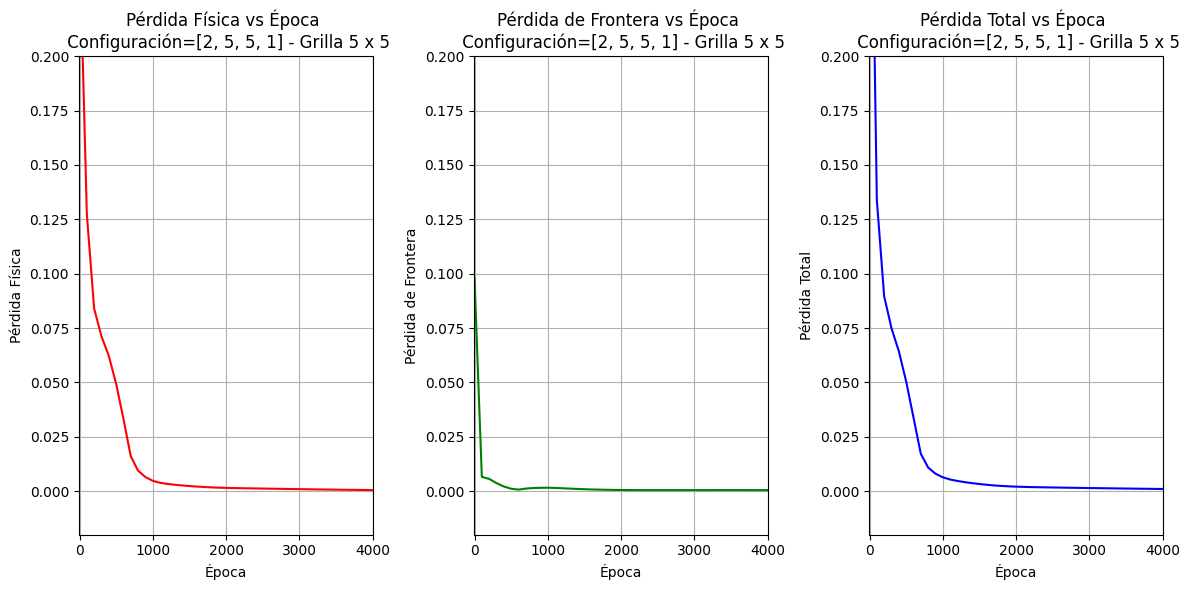

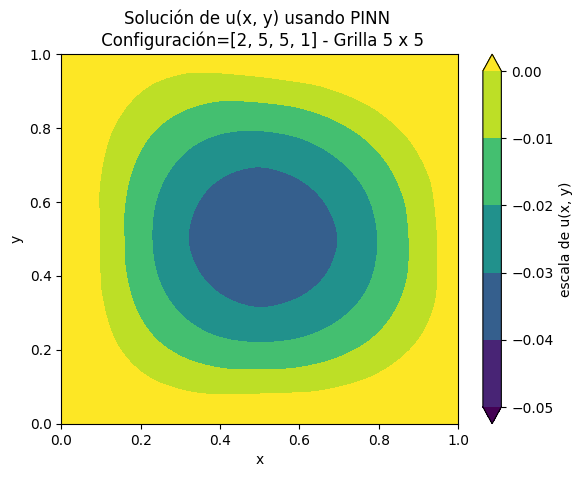

In [78]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 5x5 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua el modelo en la malla definida
u_pred_5x5 = trained_model(x, y).detach().numpy()
u_pred_5x5 = u_pred_5x5.reshape(5, 5)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_5x5.flatten(), y_5x5.flatten())).T
values = u_pred_5x5.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 5 x 5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\988094919.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_5x5.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\988094919.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev`

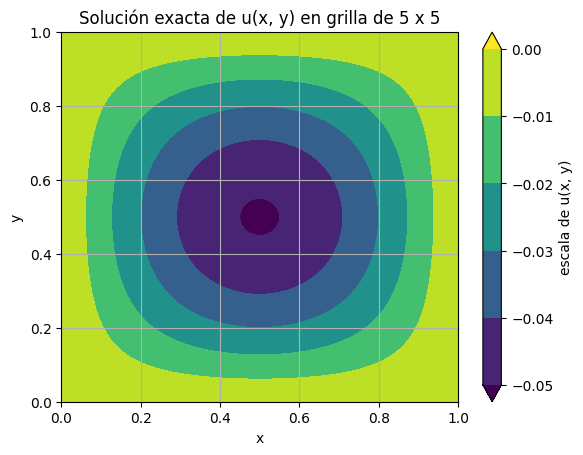

In [79]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_5x5 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_5x5.T, kind='cubic') 
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 5 x 5')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\4119999672.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_5x5, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\4119999672.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bi

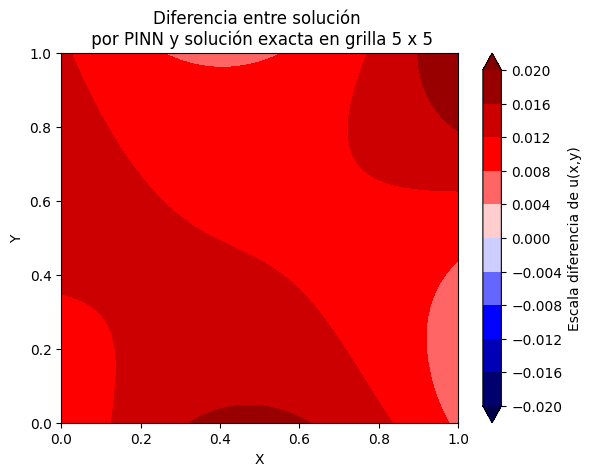

In [80]:
# Calcula la diferencia entre los dos campos
diferencia_5x5 = u_pred_5x5 - u_SE_5x5

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_5x5.shape[1])
y = np.linspace(0, 1, diferencia_5x5.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_5x5, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.020, -0.016, -0.012, -0.008, -0.004, 0.000, 0.004, 0.008, 0.012, 0.016, 0.020], vmin=-0.020, vmax=0.020, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.020, -0.016, -0.012, -0.008, -0.004, 0.000, 0.004, 0.008, 0.012, 0.016, 0.020])
plt.title('Diferencia entre solución \n por PINN y solución exacta en grilla 5 x 5')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_5x5

### II - Grilla de 10 x 10:

Epoch 0, Loss: 0.47416359186172485
Epoch 100, Loss: 0.12662193179130554
Epoch 200, Loss: 0.0899682343006134
Epoch 300, Loss: 0.07897450774908066
Epoch 400, Loss: 0.06677962094545364
Epoch 500, Loss: 0.05624726042151451
Epoch 600, Loss: 0.04816171154379845
Epoch 700, Loss: 0.0354238860309124
Epoch 800, Loss: 0.020544424653053284
Epoch 900, Loss: 0.014328726567327976
Epoch 1000, Loss: 0.01216917298734188
Epoch 1100, Loss: 0.010950727388262749
Epoch 1200, Loss: 0.009878812357783318
Epoch 1300, Loss: 0.008835858665406704
Epoch 1400, Loss: 0.00781538337469101
Epoch 1500, Loss: 0.006830437574535608
Epoch 1600, Loss: 0.005945753771811724
Epoch 1700, Loss: 0.005259524565190077
Epoch 1800, Loss: 0.004790192469954491
Epoch 1900, Loss: 0.00446573831140995
Epoch 2000, Loss: 0.0042120227590203285
Epoch 2100, Loss: 0.003985370043665171
Epoch 2200, Loss: 0.0037647592835128307
Epoch 2300, Loss: 0.0035426781978458166
Epoch 2400, Loss: 0.00332027580589056
Epoch 2500, Loss: 0.003104533301666379
Epoch 260

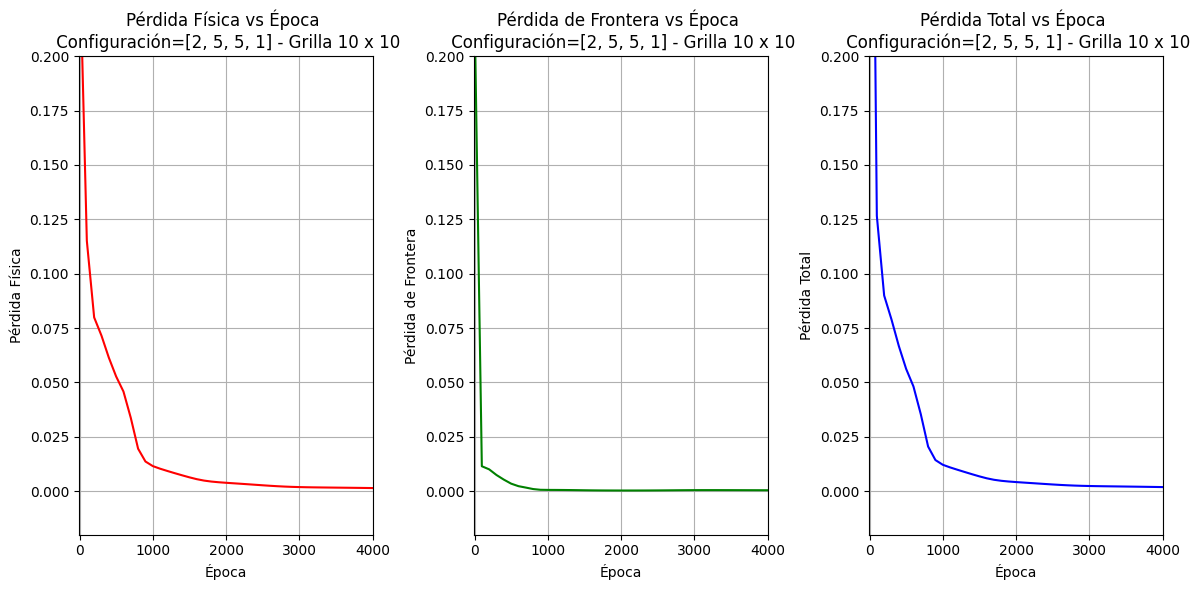

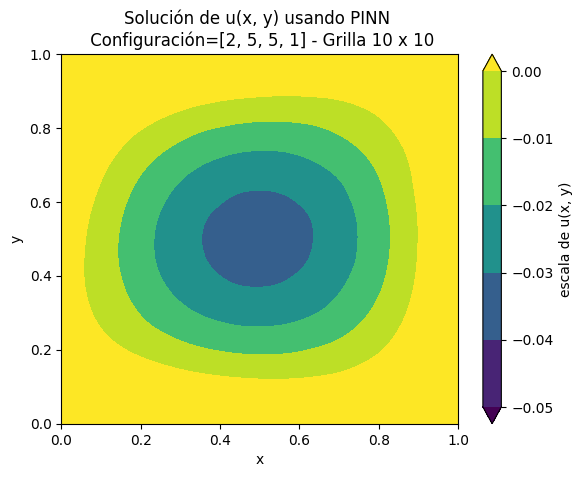

In [81]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 10x10 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua el modelo en la malla definida
u_pred_10x10 = trained_model(x, y).detach().numpy()
u_pred_10x10 = u_pred_10x10.reshape(10, 10)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_10x10.flatten(), y_10x10.flatten())).T
values = u_pred_10x10.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 10 x 10")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\879026258.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_10x10.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\879026258.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisple

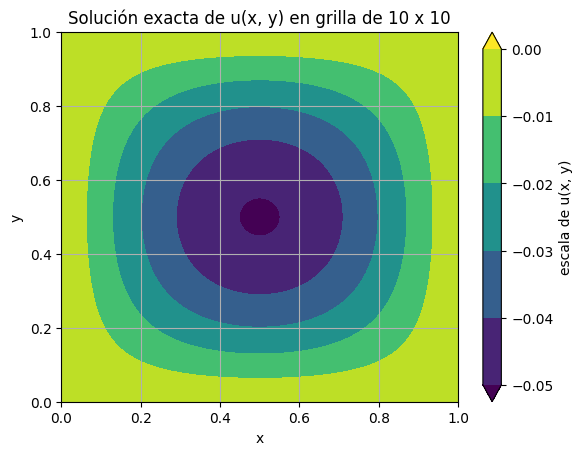

In [82]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_10x10 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_10x10.T, kind='cubic')  
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 10 x 10')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\4243493546.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_10x10, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\4243493546.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`

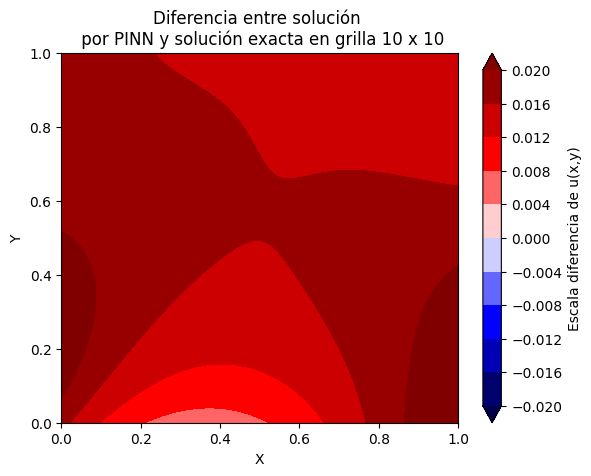

In [83]:
# Calcula la diferencia entre los dos campos
diferencia_10x10 = u_pred_10x10 - u_SE_10x10

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_10x10.shape[1])
y = np.linspace(0, 1, diferencia_10x10.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_10x10, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.020, -0.016, -0.012, -0.008, -0.004, 0.000, 0.004, 0.008, 0.012, 0.016, 0.020], vmin=-0.020, vmax=0.020, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.020, -0.016, -0.012, -0.008, -0.004, 0.000, 0.004, 0.008, 0.012, 0.016, 0.020])
plt.title('Diferencia entre solución \n por PINN y solución exacta en grilla 10 x 10')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_10x10

### III - Grilla de 20 x 20:

Epoch 0, Loss: 0.23878002166748047
Epoch 100, Loss: 0.08631519973278046
Epoch 200, Loss: 0.054418787360191345
Epoch 300, Loss: 0.0447348989546299
Epoch 400, Loss: 0.03436310589313507
Epoch 500, Loss: 0.01850144751369953
Epoch 600, Loss: 0.009039625525474548
Epoch 700, Loss: 0.0058718156069517136
Epoch 800, Loss: 0.004815638996660709
Epoch 900, Loss: 0.00408063642680645
Epoch 1000, Loss: 0.0034404213074594736
Epoch 1100, Loss: 0.002928004367277026
Epoch 1200, Loss: 0.0025669459719210863
Epoch 1300, Loss: 0.0023318822495639324
Epoch 1400, Loss: 0.002171130385249853
Epoch 1500, Loss: 0.0020447466522455215
Epoch 1600, Loss: 0.001933185150846839
Epoch 1700, Loss: 0.001828812644816935
Epoch 1800, Loss: 0.0017289514653384686
Epoch 1900, Loss: 0.0016328515484929085
Epoch 2000, Loss: 0.0015405442100018263
Epoch 2100, Loss: 0.001452348311431706
Epoch 2200, Loss: 0.0013686474412679672
Epoch 2300, Loss: 0.0012897815322503448
Epoch 2400, Loss: 0.0012160001788288355
Epoch 2500, Loss: 0.0011474422644

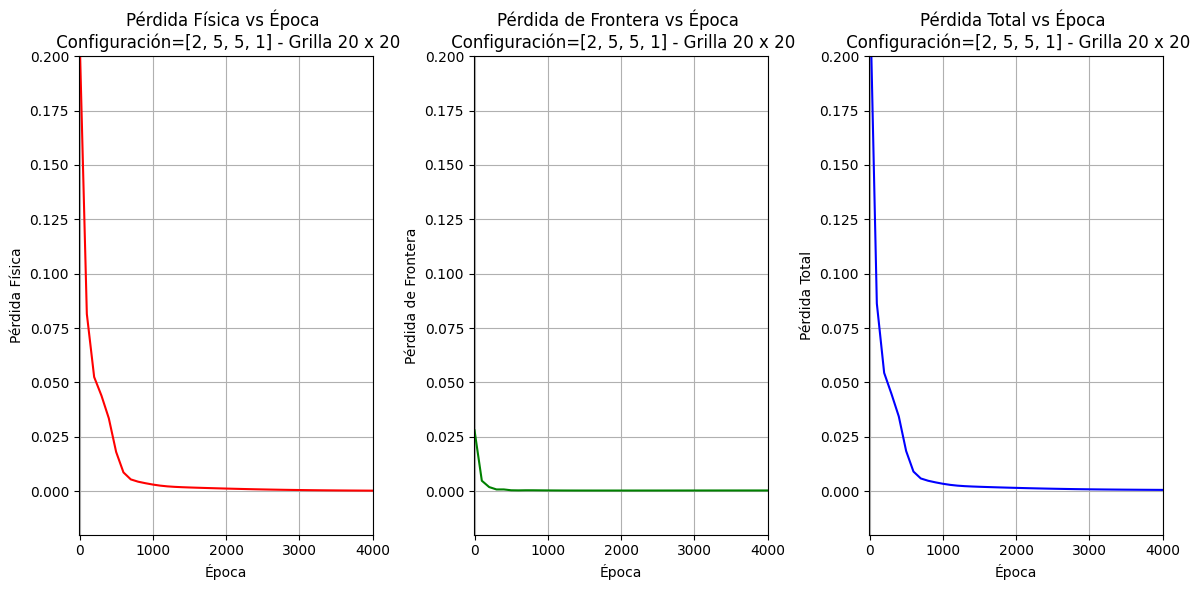

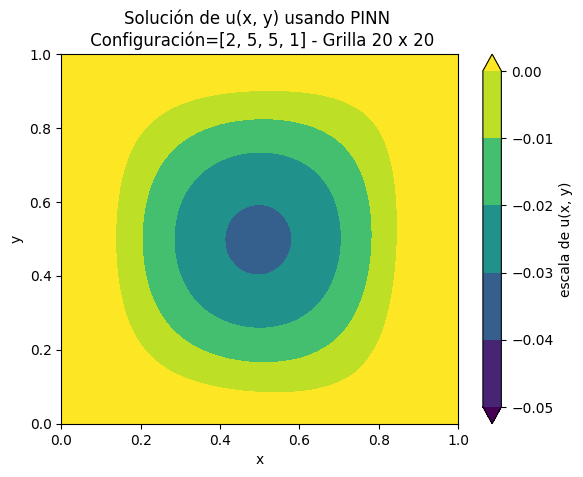

In [84]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 5)  # Entrada
        self.fc2 = nn.Linear(5, 5)  # Capa oculta 1
        self.fc3 = nn.Linear(5, 1)  # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 20x20 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua el modelo en la malla definida
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_20x20.flatten(), y_20x20.flatten())).T
values = u_pred_20x20.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 5, 5, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\3261108849.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\3261108849.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisp

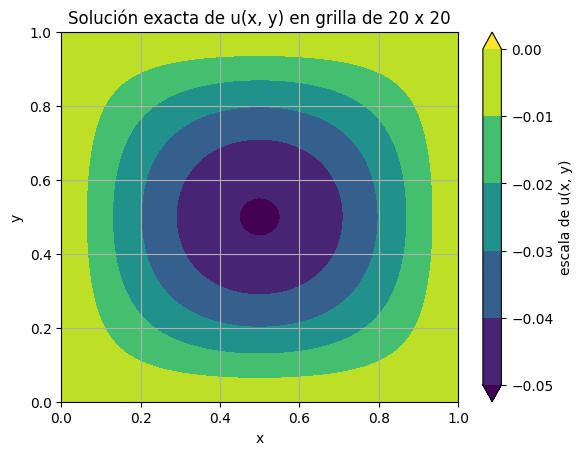

In [85]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')  
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferenicia

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\3268369476.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\3268369476.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`

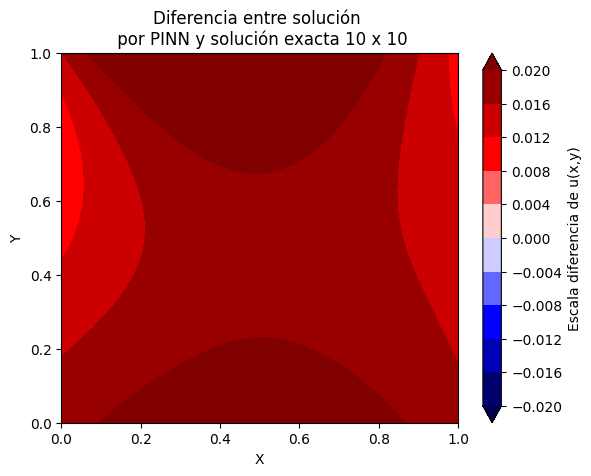

In [ ]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.020, -0.016, -0.012, -0.008, -0.004, 0.000, 0.004, 0.008, 0.012, 0.016, 0.020], vmin=-0.020, vmax=0.020, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.020, -0.016, -0.012, -0.008, -0.004, 0.000, 0.004, 0.008, 0.012, 0.016, 0.020])
plt.title('Diferencia entre solución \n por PINN y solución exacta 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20

## C - Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,10,10,1]

### I - Grilla de 5 x 5:

Epoch 0, Loss: 0.14453378319740295
Epoch 100, Loss: 0.07789603620767593
Epoch 200, Loss: 0.01882055401802063
Epoch 300, Loss: 0.006037871353328228
Epoch 400, Loss: 0.0028371005319058895
Epoch 500, Loss: 0.0018399048130959272
Epoch 600, Loss: 0.001477462938055396
Epoch 700, Loss: 0.0012983479537069798
Epoch 800, Loss: 0.0011723331408575177
Epoch 900, Loss: 0.0010695519158616662
Epoch 1000, Loss: 0.000981820048764348
Epoch 1100, Loss: 0.0009052767418324947
Epoch 1200, Loss: 0.0008368422277271748
Epoch 1300, Loss: 0.0007737163687124848
Epoch 1400, Loss: 0.0007139950757846236
Epoch 1500, Loss: 0.0006574453436769545
Epoch 1600, Loss: 0.0006049371440894902
Epoch 1700, Loss: 0.0005573162925429642
Epoch 1800, Loss: 0.0005150536890141666
Epoch 1900, Loss: 0.00047775672283023596
Epoch 2000, Loss: 0.00044454916496761143
Epoch 2100, Loss: 0.0004149267915636301
Epoch 2200, Loss: 0.00038886198308318853
Epoch 2300, Loss: 0.0003664407122414559
Epoch 2400, Loss: 0.0003475428675301373
Epoch 2500, Loss: 

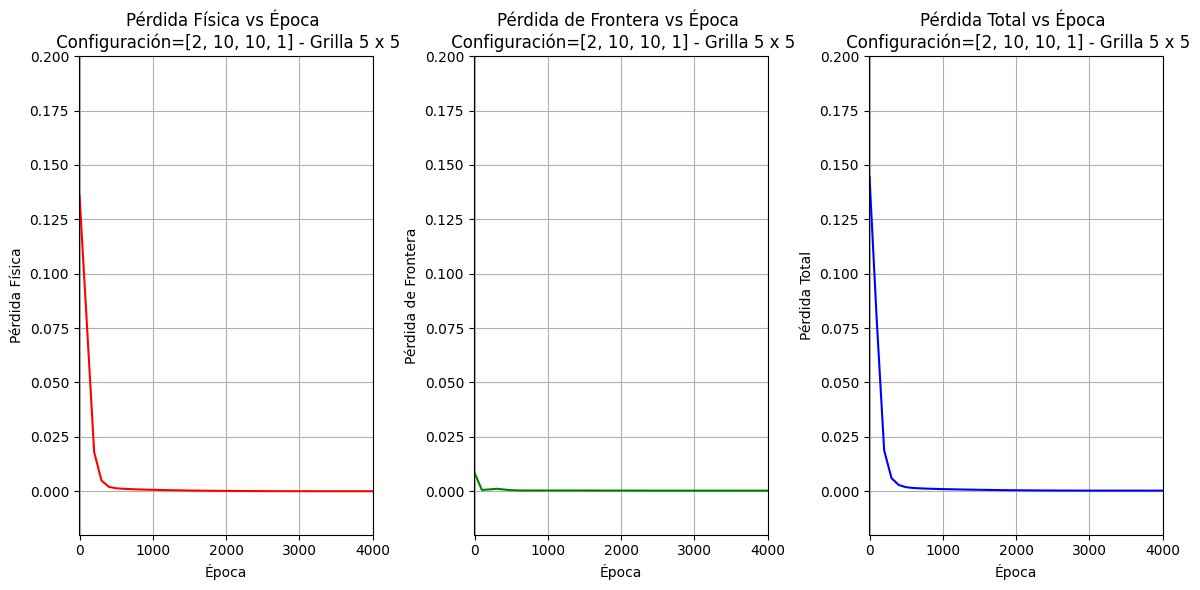

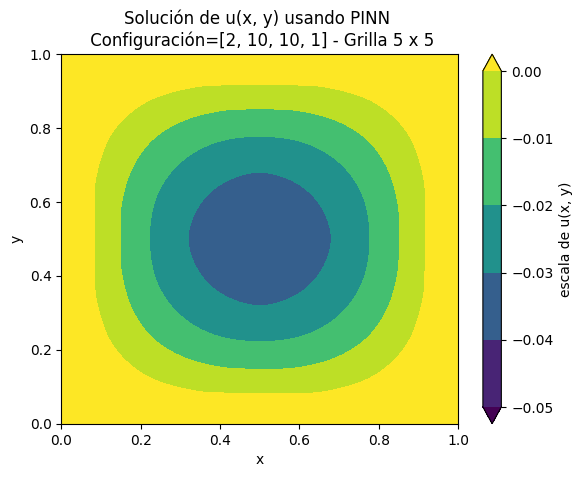

In [87]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)   # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 5x5 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 5).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua el modelo en la malla definida
u_pred_5x5 = trained_model(x, y).detach().numpy()
u_pred_5x5 = u_pred_5x5.reshape(5, 5)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_5x5 = x.reshape(5, 5).detach().numpy()
y_5x5 = y.reshape(5, 5).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_5x5.flatten(), y_5x5.flatten())).T
values = u_pred_5x5.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 1] - Grilla 5 x 5")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\988094919.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_5x5.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\988094919.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev`

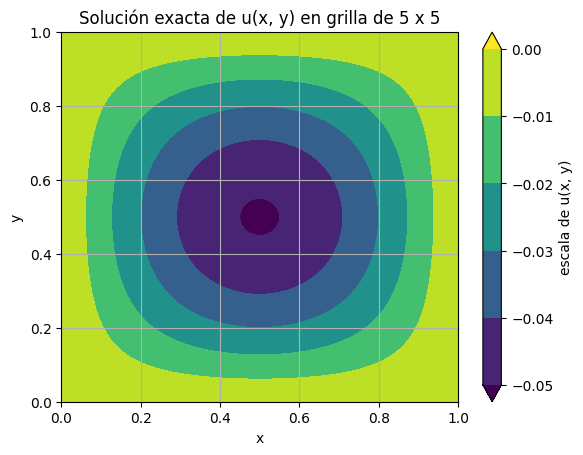

In [88]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 5x5 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 5)
y = np.linspace(0, 1, 5)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_5x5 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_5x5.T, kind='cubic') 
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 5 x 5')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\2952687564.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_5x5, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\2952687564.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bi

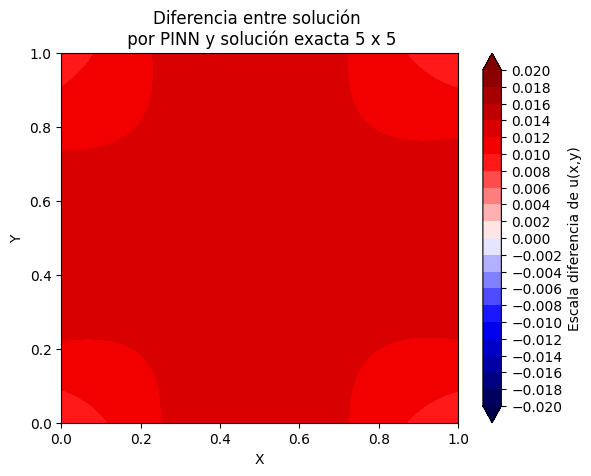

In [90]:
# Calcula la diferencia entre los dos campos
diferencia_5x5 = u_pred_5x5 - u_SE_5x5

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_5x5.shape[1])
y = np.linspace(0, 1, diferencia_5x5.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_5x5, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.020, -0.018, -0.016, -0.014, -0.012, -0.010, -0.008, -0.006, -0.004, -0.002, 0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018, 0.020], vmin=-0.020, vmax=0.020, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.020, -0.018, -0.016, -0.014, -0.012, -0.010, -0.008, -0.006, -0.004, -0.002, 0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018, 0.020])
plt.title('Diferencia entre solución \n por PINN y solución exacta 5 x 5')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_5x5

### II - Grilla de 10 x 10:

Epoch 0, Loss: 0.3042606711387634
Epoch 100, Loss: 0.10968982428312302
Epoch 200, Loss: 0.055581700056791306
Epoch 300, Loss: 0.03038426674902439
Epoch 400, Loss: 0.01172597799450159
Epoch 500, Loss: 0.008110230788588524
Epoch 600, Loss: 0.005450177472084761
Epoch 700, Loss: 0.0035350113175809383
Epoch 800, Loss: 0.002317950828000903
Epoch 900, Loss: 0.001700791995972395
Epoch 1000, Loss: 0.0014238172443583608
Epoch 1100, Loss: 0.00127517175860703
Epoch 1200, Loss: 0.0011730296537280083
Epoch 1300, Loss: 0.001090566860511899
Epoch 1400, Loss: 0.0010193660855293274
Epoch 1500, Loss: 0.0009562498889863491
Epoch 1600, Loss: 0.0008994536474347115
Epoch 1700, Loss: 0.0008476913208141923
Epoch 1800, Loss: 0.0007999578956514597
Epoch 1900, Loss: 0.0007554850890301168
Epoch 2000, Loss: 0.0007137262728065252
Epoch 2100, Loss: 0.0006743611302226782
Epoch 2200, Loss: 0.0006372982170432806
Epoch 2300, Loss: 0.0006026523187756538
Epoch 2400, Loss: 0.0005706570809707046
Epoch 2500, Loss: 0.000541526

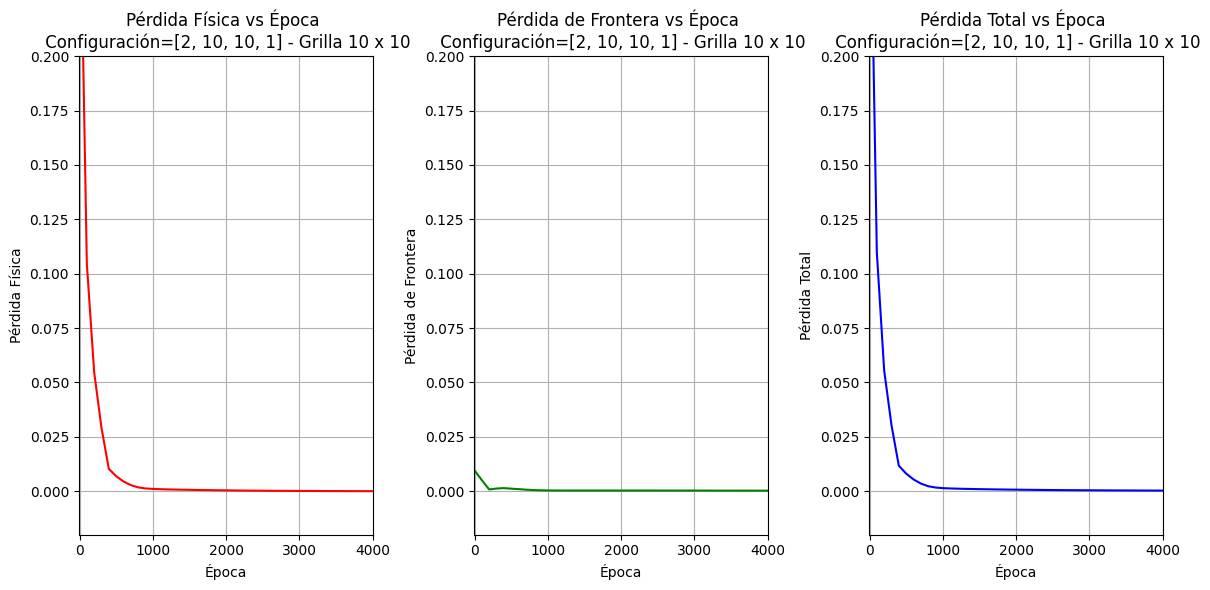

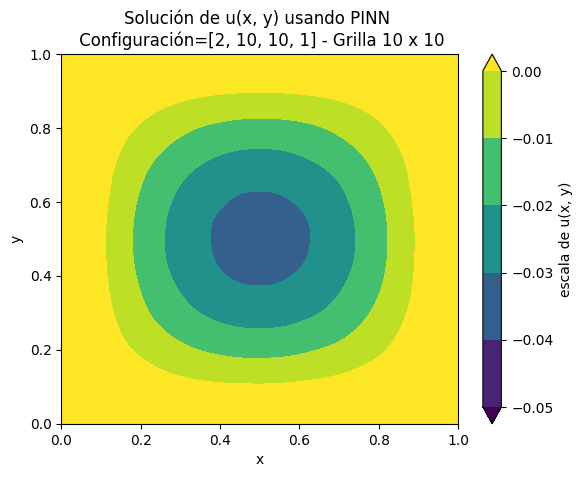

In [91]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)   # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 10x10 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 10).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua el modelo en la malla definida
u_pred_10x10 = trained_model(x, y).detach().numpy()
u_pred_10x10 = u_pred_10x10.reshape(10, 10)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_10x10 = x.reshape(10, 10).detach().numpy()
y_10x10 = y.reshape(10, 10).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_10x10.flatten(), y_10x10.flatten())).T
values = u_pred_10x10.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 1] - Grilla 10 x 10")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\879026258.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_10x10.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\879026258.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisple

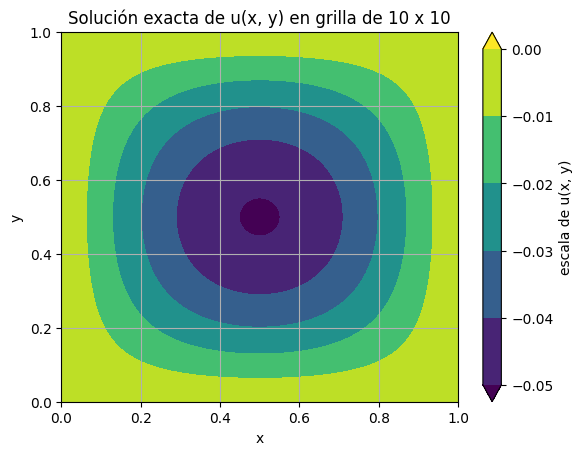

In [92]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_10x10 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_10x10.T, kind='cubic')  
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 10 x 10')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencias

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\2319401424.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_10x10, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\2319401424.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`

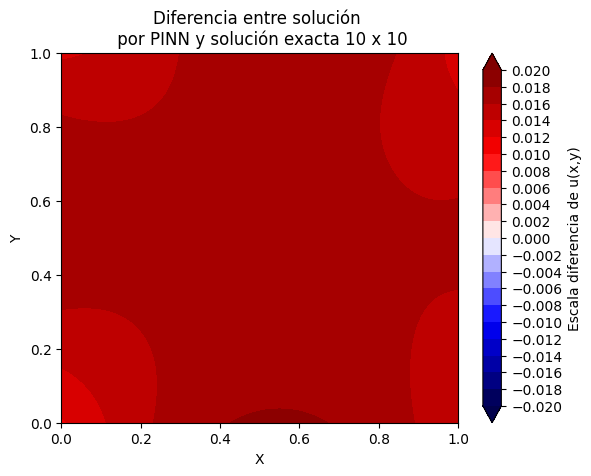

In [93]:
# Calcula la diferencia entre los dos campos
diferencia_10x10 = u_pred_10x10 - u_SE_10x10

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_10x10.shape[1])
y = np.linspace(0, 1, diferencia_10x10.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_10x10, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.020, -0.018, -0.016, -0.014, -0.012, -0.010, -0.008, -0.006, -0.004, -0.002, 0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018, 0.020], vmin=-0.020, vmax=0.020, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.020, -0.018, -0.016, -0.014, -0.012, -0.010, -0.008, -0.006, -0.004, -0.002, 0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018, 0.020])
plt.title('Diferencia entre solución \n por PINN y solución exacta 10 x 10')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_10x10

### III - Grilla de 20 x 20:

Epoch 0, Loss: 0.32181963324546814
Epoch 100, Loss: 0.09084688872098923
Epoch 200, Loss: 0.06717250496149063
Epoch 300, Loss: 0.043390680104494095
Epoch 400, Loss: 0.018542949110269547
Epoch 500, Loss: 0.006654519122093916
Epoch 600, Loss: 0.005375120788812637
Epoch 700, Loss: 0.0046341149136424065
Epoch 800, Loss: 0.003992172889411449
Epoch 900, Loss: 0.003422098932787776
Epoch 1000, Loss: 0.0029330370016396046
Epoch 1100, Loss: 0.0025331773795187473
Epoch 1200, Loss: 0.0022215363569557667
Epoch 1300, Loss: 0.001986031187698245
Epoch 1400, Loss: 0.0018069191137328744
Epoch 1500, Loss: 0.001663886709138751
Epoch 1600, Loss: 0.001541733043268323
Epoch 1700, Loss: 0.0014316553715616465
Epoch 1800, Loss: 0.001329553546383977
Epoch 1900, Loss: 0.0012339148670434952
Epoch 2000, Loss: 0.0011444070842117071
Epoch 2100, Loss: 0.001061173272319138
Epoch 2200, Loss: 0.0009845015592873096
Epoch 2300, Loss: 0.0009146456141024828
Epoch 2400, Loss: 0.0008517061942256987
Epoch 2500, Loss: 0.000795555

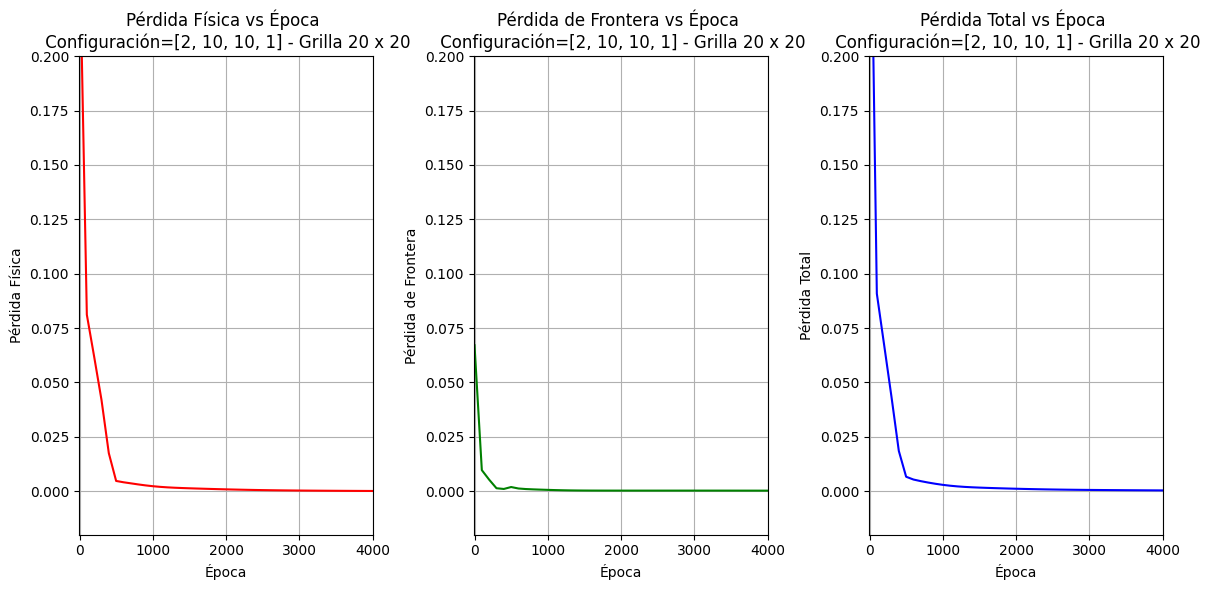

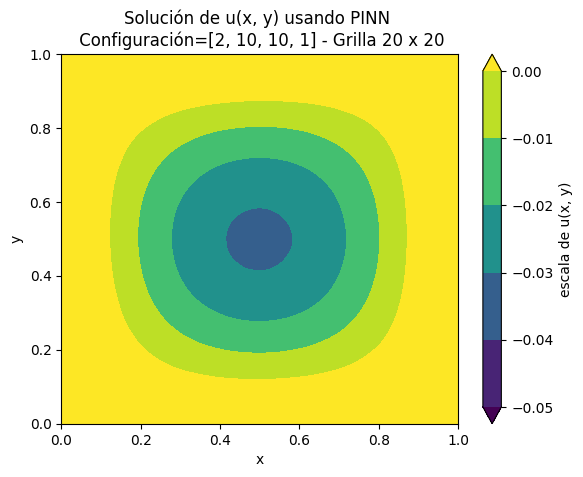

In [94]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 1)   # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 20x20 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua el modelo en la malla definida
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Interpola los resultados en una grilla fina
x_fino = np.linspace(0.0, 1.0, 1000)
y_fino = np.linspace(0.0, 1.0, 1000)
X_fino, Y_fino = np.meshgrid(x_fino, y_fino)

# Aplanar datos de entrada
points = np.vstack((x_20x20.flatten(), y_20x20.flatten())).T
values = u_pred_20x20.flatten()

# Interpolación
u_pred_fino = griddata(points, values, (X_fino, Y_fino), method='cubic')

# Visualización de los resultados interpolados
cp = plt.contourf(X_fino, Y_fino, u_pred_fino, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\3261108849.py:19: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\3261108849.py:20: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisp

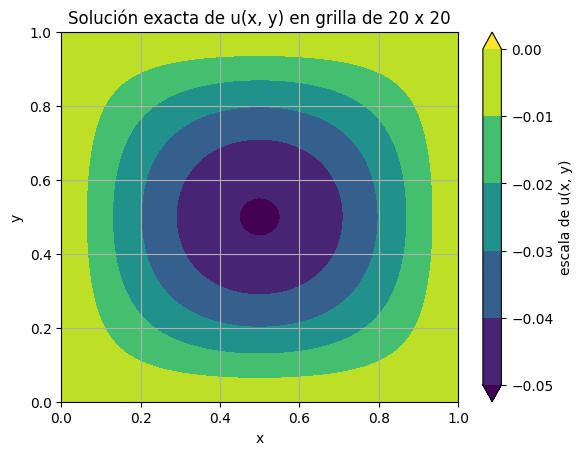

In [95]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Longitud en las direcciones x e y
Lx, Ly = 1.0, 1.0   

# Interpolación para una grilla fina
x_fine = np.linspace(0, Lx, 1000)
y_fine = np.linspace(0, Ly, 1000)
interpolator = interp2d(x, y, u_SE_20x20.T, kind='cubic')  
u_fine = interpolator(x_fine, y_fine)

# Grafica el campo
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
cp = plt.contourf(X_fine, Y_fine, u_fine, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\2436640092.py:13: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
C:\Users\fabri\AppData\Local\Temp\ipykernel_13968\2436640092.py:14: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`

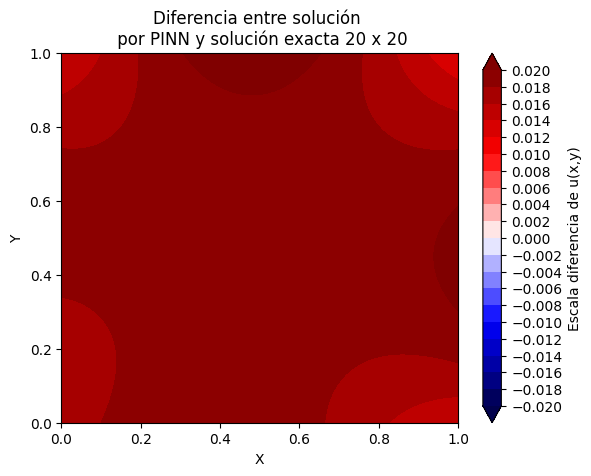

In [96]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])

# Crea la grilla fina (1000x1000) para interpolación
x_fina = np.linspace(0, 1, 1000)
y_fina = np.linspace(0, 1, 1000)

# Interpolación de la diferencia
interpolador = interp2d(x, y, diferencia_20x20, kind='cubic')
diferencia_fina = interpolador(x_fina, y_fina)

# Define la nueva grilla fina para graficar
X_fina, Y_fina = np.meshgrid(x_fina, y_fina)

# Plotea la diferencia usando contourf
plt.contourf(X_fina, Y_fina, diferencia_fina, cmap='seismic', levels=[-0.020, -0.018, -0.016, -0.014, -0.012, -0.010, -0.008, -0.006, -0.004, -0.002, 0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018, 0.020], vmin=-0.020, vmax=0.020, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.020, -0.018, -0.016, -0.014, -0.012, -0.010, -0.008, -0.006, -0.004, -0.002, 0.000, 0.002, 0.004, 0.006, 0.008, 0.010, 0.012, 0.014, 0.016, 0.018, 0.020])
plt.title('Diferencia entre solución \n por PINN y solución exacta 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20